<a href="https://colab.research.google.com/github/freddy-7/TI3002C/blob/main/6_Regresi%C3%B3n_Lineal__Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Actividad 2: María Fernanda Robles Soto A01736552

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.special as special
from scipy.optimize import curve_fit
import seaborn as sns
from sklearn.metrics import r2_score


In [13]:
#Cargar archivo csv desde seaborn
df_original = pd.read_csv("/content/listings.csv", on_bad_lines='skip', engine='python')

### Limpieza de los datos y exploración inicial

In [ ]:
#verificamos nulos
df_original.isnull().sum()

,0
id,0
listing_url,0
scrape_id,0
last_scraped,0
source,0
...,...
calculated_host_listings_count,0
calculated_host_listings_count_entire_homes,0
calculated_host_listings_count_private_rooms,0
calculated_host_listings_count_shared_rooms,0


In [ ]:
# Creamos una copia de la base de datos original para hacer la limpieza de los datos
df = df_original.copy()

# Se estandarizan nombres de columnas
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Limpiar y convertir columnas
for col in df.columns:
    if df[col].dtype == 'object':
        # Convertir porcentajes a float
        pct_mask = df[col].astype(str).str.endswith('%')
        if pct_mask.sum() / len(df[col]) > 0.1:
            df[col] = (
                df[col].str.replace('%', '', regex=False)
                        .replace('', np.nan)
                        .astype(float) / 100
            )
        else:
            # Convertir booleanos 't'/'f' a 1/0
            if df[col].isin(['t', 'f']).all():
                df[col] = df[col].map({'t': 1, 'f': 0})
            else:
                # Convertir números con símbolos a float
                df[col] = (
                    df[col].str.replace('$', '', regex=False)
                            .str.replace(',', '', regex=False)
                            .replace('', np.nan)
                )
                # Intentar convertir a float si es posible
                try:
                    df[col] = df[col].astype(float)
                except:
                    pass  # deja como object si no se puede

# Separar columnas numéricas y categóricas
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns

# Se hace la imputación de nulos
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

for col in cat_cols:
    if not df[col].mode().empty:
        df[col].fillna(df[col].mode()[0], inplace=True)

# Tratamiento de outliers
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    if IQR > 0:
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], lower_bound, upper_bound)
df

/tmp/ipython-input-47962871.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-47962871.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17878,https://www.airbnb.com/rooms/17878,20250624193519,2025-06-28,city scrape,Very Nice 2Br in Copacabana w. balcony fast WiFi,Please note that elevated rates apply for New ...,This is the one of the bests spots in Rio. Bec...,https://a0.muscache.com/pictures/65320518/3069...,68997.0,...,4.91,4.780,4.67,NaN,0,1.0,1.0,0.0,0,1.86
1,25026,https://www.airbnb.com/rooms/25026,20250624193519,2025-07-04,city scrape,Beautiful Modern Decorated Studio in Copacabana,**Fully renovated in Dec 2022 new kitchen new...,Copacabana is a lively neighborhood and the ap...,https://a0.muscache.com/pictures/7c08fa4f-1d7b...,102840.0,...,4.93,4.850,4.65,NaN,0,1.0,1.0,0.0,0,1.71
2,35764,https://www.airbnb.com/rooms/35764,20250624193519,2025-06-25,city scrape,COPACABANA SEA BREEZE - RIO - 25 X Superhost,Our newly renovated studio is located in the b...,Our guests will experience living with a local...,https://a0.muscache.com/pictures/23782972/1d3e...,153691.0,...,4.95,4.950,4.89,NaN,0,1.0,1.0,0.0,0,1.97
3,48305,https://www.airbnb.com/rooms/48305,20250624193519,2025-06-26,city scrape,Bright 6bed Penthouse Seconds from Beach,Enter Bossa Nova's history by staying in the v...,Enter Bossa Nova history by staying in the ver...,https://a0.muscache.com/pictures/miso/Hosting-...,70933.0,...,4.84,4.950,4.59,NaN,1,6.0,3.5,1.0,0,1.05
4,48901,https://www.airbnb.com/rooms/48901,20250624193519,2025-07-01,city scrape,Extra large 4BD 3BT on the AtlanticAve. Copaca...,LARGE Beach side 4 bedrooms 2 Complete bathro...,Plenty of shops entertainment andrestaurants<b...,https://a0.muscache.com/pictures/hosting/Hosti...,222884.0,...,4.83,4.940,4.60,NaN,0,1.0,1.0,0.0,0,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10912,48976456,https://www.airbnb.com/rooms/48976456,20250624193519,2025-06-25,city scrape,Um oásis no Aterro do Flamengo,Very well located apartment in the embankment ...,Copacabana is one of the best known neighborho...,https://a0.muscache.com/pictures/4402f919-bf70...,69109593.0,...,4.83,4.860,4.82,NaN,0,1.0,1.0,0.0,0,1.97
10913,48829489,https://www.airbnb.com/rooms/48829489,20250624193519,2025-06-28,city scrape,Sofisticado apto perto da praia Olegário e Metrô,The building is new and was designed for all r...,This apartment was entirely planned for our re...,https://a0.muscache.com/pictures/eccb184d-6754...,171851293.0,...,5.00,4.980,4.91,NaN,0,1.0,1.0,0.0,0,0.96
10914,48846460,https://www.airbnb.com/rooms/48846460,20250624193519,2025-06-27,city scrape,Tc308 Studio na Praia | Espaçoso e aconchegante,Apartment overlooking the back street of Aveni...,Copacabana is one of the best known neighborho...,https://a0.muscache.com/pictures/prohost-api/H...,164822022.0,...,4.75,4.750,4.50,NaN,1,8.5,3.5,0.0,0,0.39
10915,48847165,https://www.airbnb.com/rooms/48847165,20250624193519,2025-07-04,city scrape,RIO DE JANEIRO - PRAIA DO RECREIO - Reformado ...,Renovated Apartment - (2 BEDROOMS) 01 suite (b...,Recreio <br />Neighborhood family and peace of...,https://a0.muscache.com/pictures/miso/Hosting-...,246453857.5,...,4.70,4.715,4.54,NaN,0,1.0,1.0,0.0,0,0.25


### REGRESIÓN NO LINEAL

#### Modelos y correlación entre las variables

host_response_rate



In [14]:
#  host_response_rate

# Seleccionar solo columnas numéricas
num_cols = df.select_dtypes(include=np.number).columns

# Correlación de review_scores_rating con todas las numéricas
corr_review = df[num_cols].corrwith(df["host_response_rate"]).sort_values(ascending=False)

print(corr_review)

host_response_rate                              1.000000
host_acceptance_rate                            0.421313
estimated_occupancy_l365d                       0.195262
number_of_reviews_ltm                           0.193770
estimated_revenue_l365d                         0.188352
number_of_reviews_ly                            0.174438
reviews_per_month                               0.164886
number_of_reviews                               0.163727
number_of_reviews_l30d                          0.127038
instant_bookable                                0.094294
maximum_minimum_nights                          0.071804
calculated_host_listings_count_entire_homes     0.066943
review_scores_cleanliness                       0.062423
review_scores_value                             0.053861
review_scores_communication                     0.051767
review_scores_rating                            0.050761
review_scores_accuracy                          0.047373
host_listings_count            

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Modelo 1

Primeras 10 predicciones: [0.9918813  1.00676975 0.97659169 0.97204731 0.99603791 1.00629442
 0.87214991 0.97659169 0.87214991 0.88326275]


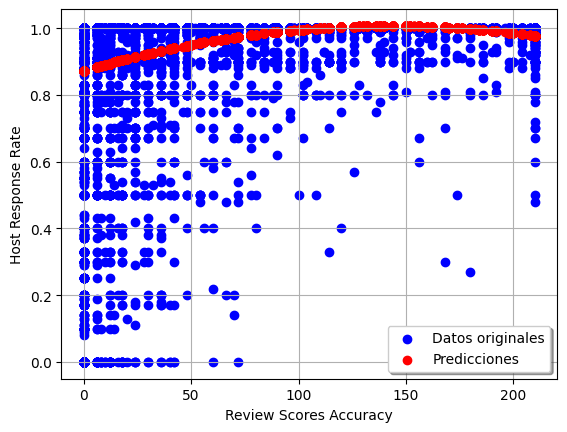

Coeficientes del modelo (a, b, c): [-6.64117089e-06  1.89198768e-03  8.72149909e-01]
R2 del modelo: 0.050422415959194056
R (correlación) del modelo: 0.22454936196568018


In [28]:
# Variables independientes y dependiente
x = df['estimated_occupancy_l365d'].values
y = df['host_response_rate'].values

# Definimos la función cuadrática
def func1(x, a, b, c):
    return a*x**2 + b*x + c

# Ajustamos los parámetros de la función
parametros1, covs = curve_fit(func1, x, y)


# Realizamos las predicciones
y_pred1 = func1(x, *parametros1)

# Mostramos las primeras predicciones
print("Primeras 10 predicciones:", y_pred1[:10])

# Graficamos los datos originales y las predicciones
plt.scatter(x, y, color='blue', label="Datos originales")
plt.scatter(x, y_pred1, color='red', label="Predicciones")
plt.xlabel('Review Scores Accuracy')
plt.ylabel('Host Response Rate')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

# Mostramos los coeficientes ajustados
print("Coeficientes del modelo (a, b, c):", parametros1)

# Calculamos el coeficiente de determinación y correlación
R2_Modelo1 = r2_score(y, y_pred1)
R_Modelo1 = np.sqrt(R2_Modelo1)

print("R2 del modelo:", R2_Modelo1)
print("R (correlación) del modelo:", R_Modelo1)


Modelo 2

Coeficientes del modelo (a, b, c): [-6.64117089e-06  1.89198768e-03  8.72149909e-01]
Primeras 10 predicciones: [0.9918813  1.00676975 0.97659169 0.97204731 0.99603791 1.00629442
 0.87214991 0.97659169 0.87214991 0.88326275]


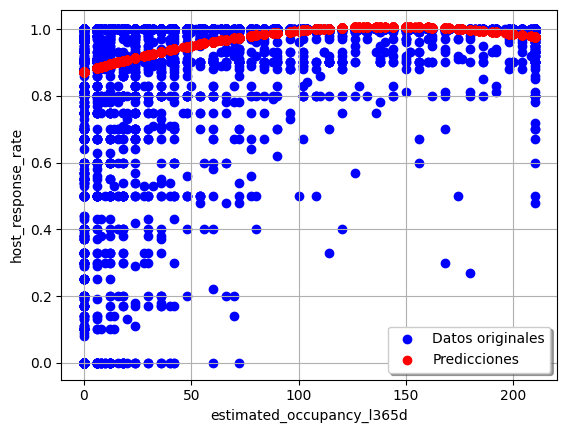

R² del modelo: 0.050422415959194056
R (correlación) del modelo: 0.22454936196568018


In [38]:
# Variables independientes y dependiente
x = df['estimated_occupancy_l365d'].values
y = df['host_response_rate'].values

# Definimos la función correctamente
def func2(x, a, b, c):
    return (a*x**2 + b) / (c*x**2)

# Ajustamos los parámetros de la función
parametros2, covs2 = curve_fit(func2, x, y)

# Mostramos los coeficientes ajustados
print("Coeficientes del modelo (a, b, c):", parametros2)

# Realizamos las predicciones
y_pred2 = func2(x, *parametros2)
print("Primeras 10 predicciones:", y_pred2[:10])

# Graficamos los datos originales y las predicciones
plt.scatter(x, y, color='blue', label="Datos originales")
plt.scatter(x, y_pred2, color='red', label="Predicciones")
plt.xlabel('Speeding')
plt.ylabel('Total')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

# Calculamos el coeficiente de determinación y correlación
R2_Modelo2 = r2_score(y, y_pred2)
R_Modelo2 = np.sqrt(abs(R2_Modelo2))  # usamos abs por si R² es negativo

print("R² del modelo:", R2_Modelo2)
print("R (correlación) del modelo:", R_Modelo2)


host_acceptance_rate

In [18]:
# host_acceptance_rate

# Seleccionar solo columnas numéricas
num_cols = df.select_dtypes(include=np.number).columns

# Correlación de review_scores_rating con todas las numéricas
corr_review = df[num_cols].corrwith(df["host_acceptance_rate"]).sort_values(ascending=False)

print(corr_review)

host_acceptance_rate                            1.000000
host_response_rate                              0.421313
number_of_reviews_ltm                           0.397111
estimated_occupancy_l365d                       0.390775
number_of_reviews_ly                            0.379109
reviews_per_month                               0.376936
number_of_reviews                               0.369635
estimated_revenue_l365d                         0.347519
instant_bookable                                0.312533
number_of_reviews_l30d                          0.253219
maximum_minimum_nights                          0.067127
host_id                                         0.064508
id                                              0.060085
review_scores_value                             0.057968
maximum_maximum_nights                          0.057581
calculated_host_listings_count_entire_homes     0.047330
maximum_nights_avg_ntm                          0.044104
review_scores_cleanliness      

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Modelo 1

Primeras 10 predicciones: [0.95917477 0.96478253 0.92496554 0.77712024 0.94863625 0.95917477
 0.65086823 0.92496554 0.65086823 0.67869685]


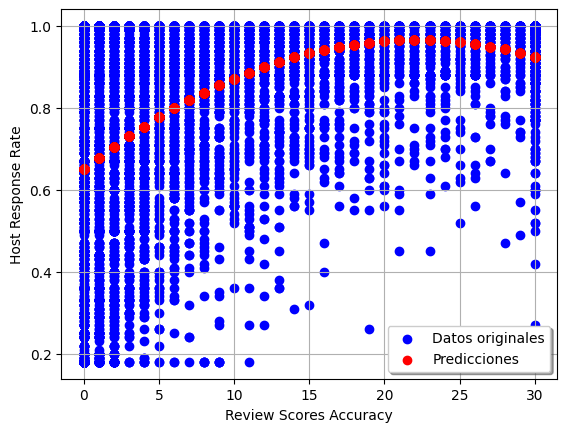

Coeficientes del modelo (a, b, c): [-6.44552988e-04  2.84731664e-02  6.50868234e-01]
R2 del modelo: 0.19101481516147922
R (correlación) del modelo: 0.43705241694959107


In [29]:
# Variables independientes y dependiente
x = df['number_of_reviews_ltm'].values
y = df['host_acceptance_rate'].values

# Definimos la función cuadrática
def func1(x, a, b, c):
    return a*x**2 + b*x + c

# Ajustamos los parámetros de la función
parametros1, covs = curve_fit(func1, x, y)

# Realizamos las predicciones
y_pred1 = func1(x, *parametros1)

# Mostramos las primeras predicciones
print("Primeras 10 predicciones:", y_pred1[:10])

# Graficamos los datos originales y las predicciones
plt.scatter(x, y, color='blue', label="Datos originales")
plt.scatter(x, y_pred1, color='red', label="Predicciones")
plt.xlabel('Review Scores Accuracy')
plt.ylabel('Host Response Rate')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

# Mostramos los coeficientes ajustados
print("Coeficientes del modelo (a, b, c):", parametros1)

# Calculamos el coeficiente de determinación y correlación
R2_Modelo1 = r2_score(y, y_pred1)
R_Modelo1 = np.sqrt(R2_Modelo1)

print("R2 del modelo:", R2_Modelo1)
print("R (correlación) del modelo:", R_Modelo1)

Modelo 2

Coeficientes del modelo (a, b, c): [-6.44552988e-04  2.84731664e-02  6.50868234e-01]
Primeras 10 predicciones: [0.95917477 0.96478253 0.92496554 0.77712024 0.94863625 0.95917477
 0.65086823 0.92496554 0.65086823 0.67869685]


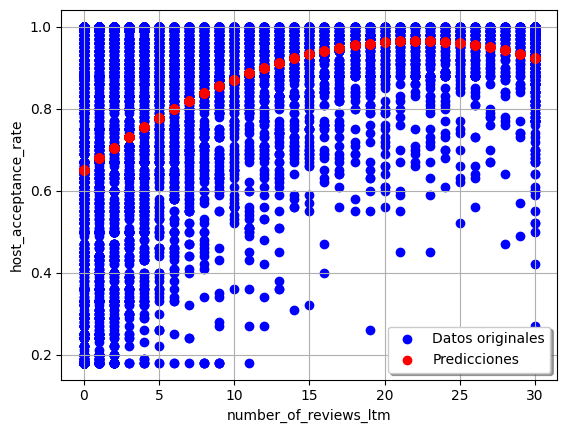

R2 del modelo: 0.19101481516147922
R (correlación) del modelo: 0.43705241694959107


In [40]:
# Variables independientes y dependiente
x = df['number_of_reviews_ltm'].values
y = df['host_acceptance_rate'].values

# Definimos la función cuadrática
def func2(x, a, b, c):
    return a*x**2 + b*x + c

# Ajustamos los parámetros de la función
parametros2, covs2 = curve_fit(func2, x, y)

# Mostramos los coeficientes ajustados
print("Coeficientes del modelo (a, b, c):", parametros2)

# Realizamos las predicciones
y_pred2 = func2(x, *parametros2)
print("Primeras 10 predicciones:", y_pred2[:10])

# Graficamos los datos originales y las predicciones
plt.scatter(x, y, color='blue', label="Datos originales")
plt.scatter(x, y_pred2, color='red', label="Predicciones")
plt.xlabel('number_of_reviews_ltm')
plt.ylabel('host_acceptance_rate')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

# Calculamos el coeficiente de determinación y correlación
R2_Modelo2 = r2_score(y, y_pred2)
R_Modelo2 = np.sqrt(abs(R2_Modelo2))  # usamos abs por si R² es negativo

print("R2 del modelo:", R2_Modelo2)
print("R (correlación) del modelo:", R_Modelo2)

host_total_listings_count

In [22]:
# host_total_listings_count

# Seleccionar solo columnas numéricas
num_cols = df.select_dtypes(include=np.number).columns

# Correlación de review_scores_rating con todas las numéricas
corr_review = df[num_cols].corrwith(df['host_total_listings_count']).sort_values(ascending=False)

print(corr_review)

host_total_listings_count                       1.000000
host_listings_count                             0.913513
calculated_host_listings_count                  0.867429
calculated_host_listings_count_entire_homes     0.673150
calculated_host_listings_count_private_rooms    0.257768
instant_bookable                                0.144675
calculated_host_listings_count_shared_rooms     0.119552
id                                              0.109960
longitude                                       0.083254
accommodates                                    0.078527
number_of_reviews_ly                            0.060911
maximum_maximum_nights                          0.058971
estimated_revenue_l365d                         0.056184
number_of_reviews                               0.056108
estimated_occupancy_l365d                       0.045398
number_of_reviews_ltm                           0.045170
beds                                            0.033895
reviews_per_month              

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Modelo 1

Primeras 10 predicciones: [ 2.87325668  1.76375555  1.76375555 11.25548696  1.76375555 14.69144155
  7.33564992  2.87325668 13.49887794  7.33564992]


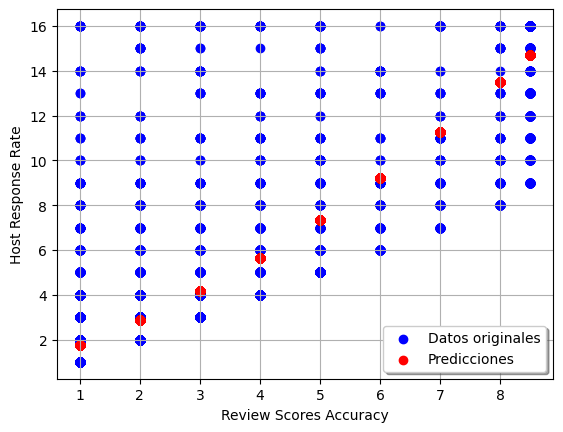

Coeficientes del modelo (a, b, c): [0.09449082 0.82602867 0.84323606]
R2 del modelo: 0.8426585749365868
R (correlación) del modelo: 0.9179643647422197


In [30]:
# Variables independientes y dependiente
x = df['host_listings_count'].values
y = df['host_total_listings_count'].values

# Definimos la función cuadrática
def func1(x, a, b, c):
    return a*x**2 + b*x + c

# Ajustamos los parámetros de la función
parametros1, covs = curve_fit(func1, x, y)

# Realizamos las predicciones
y_pred1 = func1(x, *parametros1)

# Mostramos las primeras predicciones
print("Primeras 10 predicciones:", y_pred1[:10])

# Graficamos los datos originales y las predicciones
plt.scatter(x, y, color='blue', label="Datos originales")
plt.scatter(x, y_pred1, color='red', label="Predicciones")
plt.xlabel('Review Scores Accuracy')
plt.ylabel('Host Response Rate')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

# Mostramos los coeficientes ajustados
print("Coeficientes del modelo (a, b, c):", parametros1)

# Calculamos el coeficiente de determinación y correlación
R2_Modelo1 = r2_score(y, y_pred1)
R_Modelo1 = np.sqrt(R2_Modelo1)

print("R2 del modelo:", R2_Modelo1)
print("R (correlación) del modelo:", R_Modelo1)

Modelo 2

Coeficientes del modelo (a, b, c): [0.09449082 0.82602867 0.84323606]
Primeras 10 predicciones: [ 2.87325668  1.76375555  1.76375555 11.25548696  1.76375555 14.69144155
  7.33564992  2.87325668 13.49887794  7.33564992]


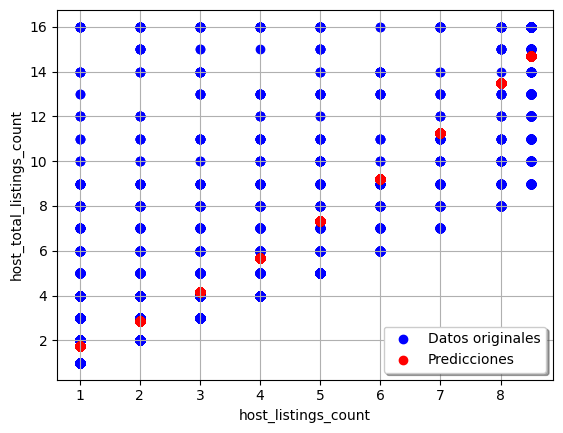

R2 del modelo: 0.8426585749365868
R (correlación) del modelo: 0.9179643647422197


In [41]:
# Variables independientes y dependiente
x = df['host_listings_count'].values
y = df['host_total_listings_count'].values

# Definimos la función cuadrática
def func2(x, a, b, c):
    return a*x**2 + b*x + c

# Ajustamos los parámetros de la función
parametros2, covs2 = curve_fit(func2, x, y)

# Mostramos los coeficientes ajustados
print("Coeficientes del modelo (a, b, c):", parametros2)

# Realizamos las predicciones
y_pred2 = func2(x, *parametros2)
print("Primeras 10 predicciones:", y_pred2[:10])

# Graficamos los datos originales y las predicciones
plt.scatter(x, y, color='blue', label="Datos originales")
plt.scatter(x, y_pred2, color='red', label="Predicciones")
plt.xlabel('host_listings_count')
plt.ylabel('host_total_listings_count')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

# Calculamos el coeficiente de determinación y correlación
R2_Modelo2 = r2_score(y, y_pred2)
R_Modelo2 = np.sqrt(abs(R2_Modelo2))  # usamos abs por si R² es negativo

print("R2 del modelo:", R2_Modelo2)
print("R (correlación) del modelo:", R_Modelo2)

accommodates

In [33]:
# accommodates

# Seleccionar solo columnas numéricas
num_cols = df.select_dtypes(include=np.number).columns

# Correlación de review_scores_rating con todas las numéricas
corr_review = df[num_cols].corrwith(df['accommodates']).sort_values(ascending=False)

print(corr_review)

accommodates                                    1.000000
beds                                            0.715223
bedrooms                                        0.705331
bathrooms                                       0.569926
price                                           0.470825
calculated_host_listings_count_entire_homes     0.220854
estimated_revenue_l365d                         0.143135
maximum_minimum_nights                          0.093330
availability_365                                0.091893
availability_eoy                                0.087476
host_total_listings_count                       0.078527
minimum_nights_avg_ntm                          0.074143
minimum_nights                                  0.070432
minimum_minimum_nights                          0.067677
host_listings_count                             0.064457
calculated_host_listings_count                  0.051042
availability_90                                 0.048987
maximum_nights                 

Modelo 1

Primeras 10 predicciones: [4.34922867 3.00395451 3.00395451 8.09051488 8.09051488 3.00395451
 8.09051488 2.57781369 3.00395451 3.00395451]


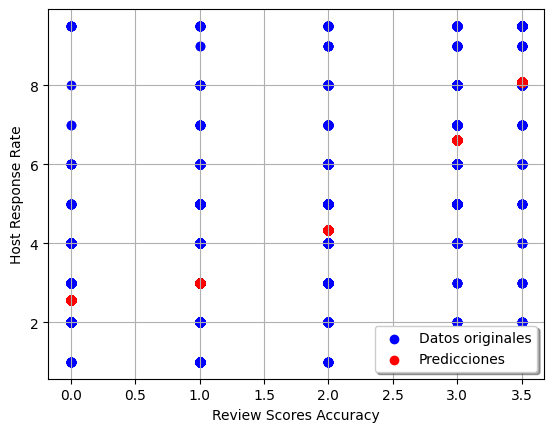

Coeficientes del modelo (a, b, c): [ 0.45956666 -0.03342584  2.57781369]
R2 del modelo: 0.5361068143553578
R (correlación) del modelo: 0.7321931537206271


In [31]:
# Variables independientes y dependiente
x = df['bedrooms'].values
y = df['accommodates'].values

# Definimos la función cuadrática
def func1(x, a, b, c):
    return a*x**2 + b*x + c

# Ajustamos los parámetros de la función
parametros1, covs = curve_fit(func1, x, y)

# Realizamos las predicciones
y_pred1 = func1(x, *parametros1)

# Mostramos las primeras predicciones
print("Primeras 10 predicciones:", y_pred1[:10])

# Graficamos los datos originales y las predicciones
plt.scatter(x, y, color='blue', label="Datos originales")
plt.scatter(x, y_pred1, color='red', label="Predicciones")
plt.xlabel('Review Scores Accuracy')
plt.ylabel('Host Response Rate')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

# Mostramos los coeficientes ajustados
print("Coeficientes del modelo (a, b, c):", parametros1)

# Calculamos el coeficiente de determinación y correlación
R2_Modelo1 = r2_score(y, y_pred1)
R_Modelo1 = np.sqrt(R2_Modelo1)

print("R2 del modelo:", R2_Modelo1)
print("R (correlación) del modelo:", R_Modelo1)

Modelo 2

Coeficientes del modelo (a, b, c): [ 0.45956666 -0.03342584  2.57781369]
Primeras 10 predicciones: [4.34922867 3.00395451 3.00395451 8.09051488 8.09051488 3.00395451
 8.09051488 2.57781369 3.00395451 3.00395451]


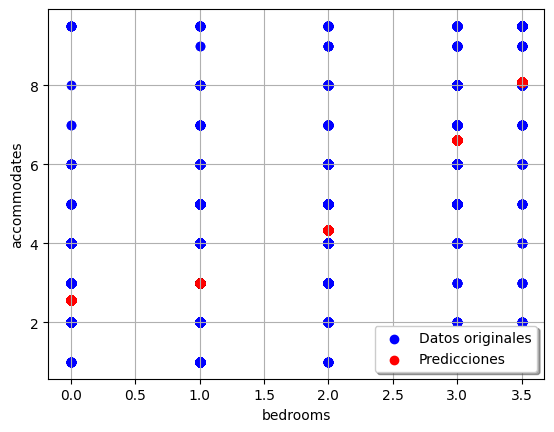

R2 del modelo: 0.5361068143553578
R (correlación) del modelo: 0.7321931537206271


In [42]:
# Variables independientes y dependiente
x = df['bedrooms'].values
y = df['accommodates'].values

# Definimos la función cuadrática
def func2(x, a, b, c):
    return a*x**2 + b*x + c

# Ajustamos los parámetros de la función
parametros2, covs2 = curve_fit(func2, x, y)

# Mostramos los coeficientes ajustados
print("Coeficientes del modelo (a, b, c):", parametros2)

# Realizamos las predicciones
y_pred2 = func2(x, *parametros2)
print("Primeras 10 predicciones:", y_pred2[:10])

# Graficamos los datos originales y las predicciones
plt.scatter(x, y, color='blue', label="Datos originales")
plt.scatter(x, y_pred2, color='red', label="Predicciones")
plt.xlabel('bedrooms')
plt.ylabel('accommodates')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

# Calculamos el coeficiente de determinación y correlación
R2_Modelo2 = r2_score(y, y_pred2)
R_Modelo2 = np.sqrt(abs(R2_Modelo2))  # usamos abs por si R² es negativo

print("R2 del modelo:", R2_Modelo2)
print("R (correlación) del modelo:", R_Modelo2)

reviews_per_month

In [32]:
# reviews_per_month

# Seleccionar solo columnas numéricas
num_cols = df.select_dtypes(include=np.number).columns

# Correlación de review_scores_rating con todas las numéricas
corr_review = df[num_cols].corrwith(df['reviews_per_month']).sort_values(ascending=False)

print(corr_review)

reviews_per_month                               1.000000
number_of_reviews                               0.887192
number_of_reviews_ly                            0.857735
number_of_reviews_ltm                           0.848981
estimated_occupancy_l365d                       0.815719
estimated_revenue_l365d                         0.680979
number_of_reviews_l30d                          0.584490
host_acceptance_rate                            0.376936
instant_bookable                                0.196934
host_response_rate                              0.164886
review_scores_value                             0.152424
id                                              0.146971
calculated_host_listings_count_entire_homes     0.138727
maximum_maximum_nights                          0.122849
longitude                                       0.119247
maximum_nights_avg_ntm                          0.113708
minimum_maximum_nights                          0.102452
host_id                        

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Modelo 1

Primeras 10 predicciones: [1.22070325 1.43069444 1.799911   0.49140237 1.11597757 1.22070325
 0.23307462 1.799911   0.23307462 0.2846502 ]


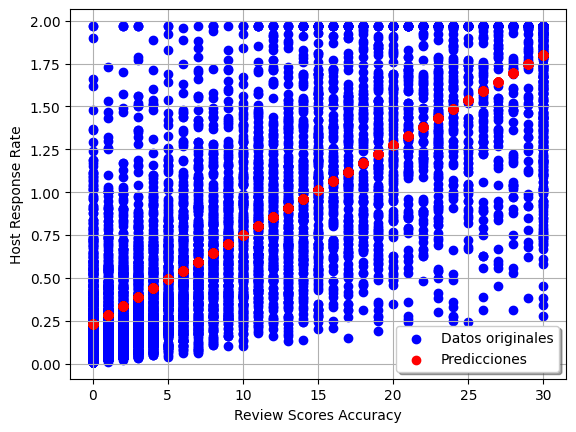

Coeficientes del modelo (a, b, c): [2.24931941e-05 5.15530835e-02 2.33074621e-01]
R2 del modelo: 0.7207767790779203
R (correlación) del modelo: 0.8489857354973169


In [34]:
# Variables independientes y dependiente
x = df['number_of_reviews_ltm'].values
y = df['reviews_per_month'].values

# Definimos la función cuadrática
def func1(x, a, b, c):
    return a*x**2 + b*x + c

# Ajustamos los parámetros de la función
parametros1, covs = curve_fit(func1, x, y)

# Realizamos las predicciones
y_pred1 = func1(x, *parametros1)

# Mostramos las primeras predicciones
print("Primeras 10 predicciones:", y_pred1[:10])

# Graficamos los datos originales y las predicciones
plt.scatter(x, y, color='blue', label="Datos originales")
plt.scatter(x, y_pred1, color='red', label="Predicciones")
plt.xlabel('Review Scores Accuracy')
plt.ylabel('Host Response Rate')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

# Mostramos los coeficientes ajustados
print("Coeficientes del modelo (a, b, c):", parametros1)

# Calculamos el coeficiente de determinación y correlación
R2_Modelo1 = r2_score(y, y_pred1)
R_Modelo1 = np.sqrt(R2_Modelo1)

print("R2 del modelo:", R2_Modelo1)
print("R (correlación) del modelo:", R_Modelo1)

Modelo 2

Coeficientes del modelo (a, b, c): [2.24931941e-05 5.15530835e-02 2.33074621e-01]
Primeras 10 predicciones: [1.22070325 1.43069444 1.799911   0.49140237 1.11597757 1.22070325
 0.23307462 1.799911   0.23307462 0.2846502 ]


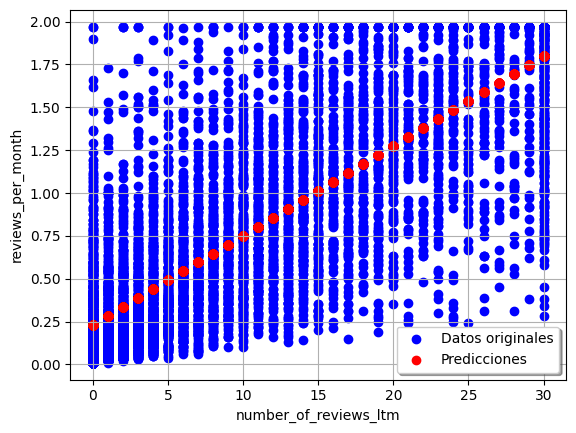

R2 del modelo: 0.7207767790779203
R (correlación) del modelo: 0.8489857354973169


In [43]:
# Variables independientes y dependiente
x = df['number_of_reviews_ltm'].values
y = df['reviews_per_month'].values

# Definimos la función cuadrática
def func2(x, a, b, c):
    return a*x**2 + b*x + c

# Ajustamos los parámetros de la función
parametros2, covs2 = curve_fit(func2, x, y)

# Mostramos los coeficientes ajustados
print("Coeficientes del modelo (a, b, c):", parametros2)

# Realizamos las predicciones
y_pred2 = func2(x, *parametros2)
print("Primeras 10 predicciones:", y_pred2[:10])

# Graficamos los datos originales y las predicciones
plt.scatter(x, y, color='blue', label="Datos originales")
plt.scatter(x, y_pred2, color='red', label="Predicciones")
plt.xlabel('number_of_reviews_ltm')
plt.ylabel('reviews_per_month')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

# Calculamos el coeficiente de determinación y correlación
R2_Modelo2 = r2_score(y, y_pred2)
R_Modelo2 = np.sqrt(abs(R2_Modelo2))  # usamos abs por si R² es negativo

print("R2 del modelo:", R2_Modelo2)
print("R (correlación) del modelo:", R_Modelo2)

In [35]:
# price

# Seleccionar solo columnas numéricas
num_cols = df.select_dtypes(include=np.number).columns

# Correlación de review_scores_rating con todas las numéricas
corr_review = df[num_cols].corrwith(df['price']).sort_values(ascending=False)

print(corr_review)

price                                           1.000000
bathrooms                                       0.551633
bedrooms                                        0.532629
accommodates                                    0.470825
beds                                            0.388487
availability_365                                0.244133
availability_30                                 0.232114
availability_eoy                                0.226293
availability_60                                 0.223571
availability_90                                 0.219753
minimum_minimum_nights                          0.216739
minimum_nights                                  0.202664
minimum_nights_avg_ntm                          0.191860
review_scores_location                          0.162871
maximum_minimum_nights                          0.159277
review_scores_checkin                           0.132397
review_scores_communication                     0.114848
review_scores_rating           

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Modelo 1

Primeras 10 predicciones: [ 563.12450288  367.35381386  367.35381386 1007.80459751 1007.80459751
  367.35381386 1007.80459751  252.12929077  367.35381386  367.35381386]


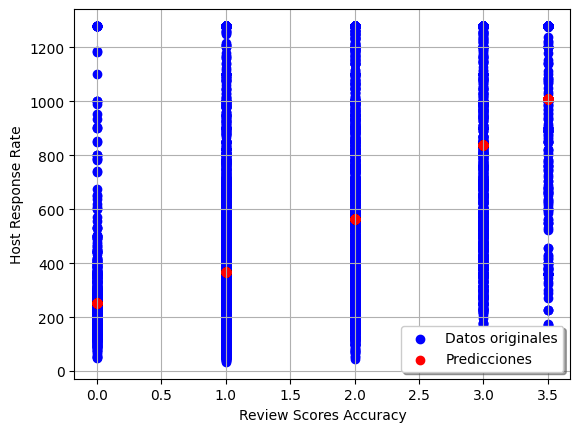

Coeficientes del modelo (a, b, c): [ 40.27308296  74.95144014 252.12929077]
R2 del modelo: 0.2929321323720847
R (correlación) del modelo: 0.5412320503925139


In [36]:
# Variables independientes y dependiente
x = df['bedrooms'].values
y = df['price'].values

# Definimos la función cuadrática
def func1(x, a, b, c):
    return a*x**2 + b*x + c

# Ajustamos los parámetros de la función
parametros1, covs = curve_fit(func1, x, y)

# Realizamos las predicciones
y_pred1 = func1(x, *parametros1)

# Mostramos las primeras predicciones
print("Primeras 10 predicciones:", y_pred1[:10])

# Graficamos los datos originales y las predicciones
plt.scatter(x, y, color='blue', label="Datos originales")
plt.scatter(x, y_pred1, color='red', label="Predicciones")
plt.xlabel('Review Scores Accuracy')
plt.ylabel('Host Response Rate')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

# Mostramos los coeficientes ajustados
print("Coeficientes del modelo (a, b, c):", parametros1)

# Calculamos el coeficiente de determinación y correlación
R2_Modelo1 = r2_score(y, y_pred1)
R_Modelo1 = np.sqrt(R2_Modelo1)

print("R2 del modelo:", R2_Modelo1)
print("R (correlación) del modelo:", R_Modelo1)

Modelo 2

Coeficientes del modelo (a, b, c): [ 40.27308296  74.95144014 252.12929077]
Primeras 10 predicciones: [ 563.12450288  367.35381386  367.35381386 1007.80459751 1007.80459751
  367.35381386 1007.80459751  252.12929077  367.35381386  367.35381386]


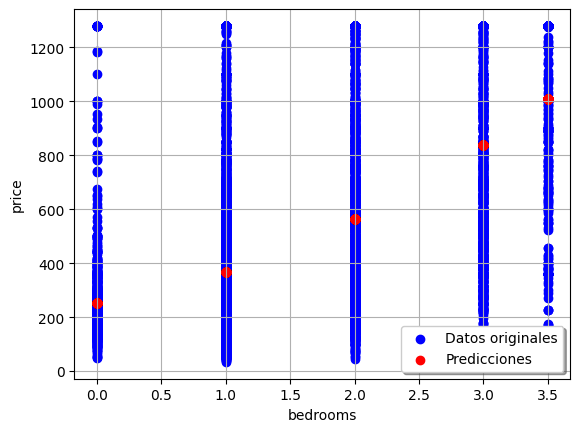

R2 del modelo: 0.2929321323720847
R (correlación) del modelo: 0.5412320503925139


In [44]:
# Variables independientes y dependiente
x = df['bedrooms'].values
y = df['price'].values

# Definimos la función cuadrática
def func2(x, a, b, c):
    return a*x**2 + b*x + c

# Ajustamos los parámetros de la función
parametros2, covs2 = curve_fit(func2, x, y)

# Mostramos los coeficientes ajustados
print("Coeficientes del modelo (a, b, c):", parametros2)

# Realizamos las predicciones
y_pred2 = func2(x, *parametros2)
print("Primeras 10 predicciones:", y_pred2[:10])

# Graficamos los datos originales y las predicciones
plt.scatter(x, y, color='blue', label="Datos originales")
plt.scatter(x, y_pred2, color='red', label="Predicciones")
plt.xlabel('bedrooms')
plt.ylabel('price')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

# Calculamos el coeficiente de determinación y correlación
R2_Modelo2 = r2_score(y, y_pred2)
R_Modelo2 = np.sqrt(abs(R2_Modelo2))  # usamos abs por si R² es negativo

print("R2 del modelo:", R2_Modelo2)
print("R (correlación) del modelo:", R_Modelo2)